In [5]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # , cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix  # , classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from scipy import integrate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support,make_scorer


/home/mauro/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mauro/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
DATA_PATH = '../data/features/'

tran = pd.read_pickle(DATA_PATH + "T.pickle")
ntran = pd.read_pickle(DATA_PATH + "NT.pickle")

In [7]:
print(tran.shape[0]+ntran.shape[0])
print(tran[tran.index.get_level_values("copy_num")==0].shape[0]+ntran.shape[0])

62152
19462


In [8]:
ntran.tail()


,,Class,ObsCount,amplitude,beyond1st,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,kurtosis,...,poly3_t3,poly4_t1,poly4_t2,poly4_t3,poly4_t4,skew,small_kurtosis,std,stetson_j,stetson_k
ID,copy_num,,,,,,,,,,,,,,,,,,,,,
CataID3033022002583,0,non-transient,26,0.735,0.346154,0.127315,0.205024,0.305707,0.490865,0.867210,-0.863844,...,-4.381506e-11,0.000071,3.879196e-07,2.814693e-11,-8.962333e-14,-0.323662,-3.396739,0.418429,-0.030355,0.808361
CataID3047011003844,0,non-transient,155,1.095,0.296774,0.108153,0.190941,0.279280,0.445071,0.671028,1.114974,...,1.064017e-10,-0.000227,9.092593e-08,2.125542e-10,-1.177270e-13,0.360834,-3.059340,0.368006,0.116535,0.750544
CataID3047011003855,0,non-transient,170,1.085,0.258824,0.133967,0.212753,0.344202,0.523757,0.743903,1.874279,...,1.183648e-10,-0.000132,-1.976342e-07,8.569407e-11,3.401031e-14,0.007305,-3.053999,0.299632,0.063073,0.721548
CataID3039011002658,0,non-transient,246,0.470,0.146341,0.131166,0.199049,0.331865,0.473950,0.731653,32.978695,...,-1.966459e-12,-0.000029,3.271956e-08,2.593368e-12,-4.841826e-15,3.637046,-3.037088,0.071074,0.157681,0.724867
CataID3039010019034,0,non-transient,41,0.980,0.463415,0.103206,0.207452,0.250963,0.286646,0.777099,-0.396448,...,-1.044907e-10,0.000071,-4.613608e-07,-1.297451e-10,2.273128e-13,-0.439782,-3.238866,0.476747,-0.001186,0.728520


In [9]:
feats = np.array(tran.columns[2:])
print(len(feats))
print(feats)

30
['amplitude' 'beyond1st' 'flux_percentile_ratio_mid20'
 'flux_percentile_ratio_mid35' 'flux_percentile_ratio_mid50'
 'flux_percentile_ratio_mid65' 'flux_percentile_ratio_mid80' 'kurtosis'
 'max_slope' 'median_absolute_deviation' 'median_buffer_range_percentage'
 'pair_slope_trend' 'pair_slope_trend_last_30' 'percent_amplitude'
 'percent_difference_flux_percentile' 'poly1_t1' 'poly2_t1' 'poly2_t2'
 'poly3_t1' 'poly3_t2' 'poly3_t3' 'poly4_t1' 'poly4_t2' 'poly4_t3'
 'poly4_t4' 'skew' 'small_kurtosis' 'std' 'stetson_j' 'stetson_k']


In [10]:
alldf = pd.concat([tran,ntran])

# Binary Classification 
Transients and non-transients 

In [11]:
def splitTrainTest(dataframe):
    test = pd.DataFrame(columns = ["ID","copy_num"]+list(dataframe.columns))
    test = test.set_index(["ID","copy_num"])

    train = pd.DataFrame(columns = ["ID","copy_num"]+list(dataframe.columns))
    train = train.set_index(["ID","copy_num"])
    for uClass in dataframe.Class.unique():
        classDf = dataframe[dataframe.Class == uClass]
        
        #ids unicos 
        ids = classDf.index.get_level_values('ID').unique()

        # escoger aleatoriamente 25% de los indices

        testInd = np.random.choice(ids, int(0.25*len(ids)),replace=False)

        #sacar dataframes
        test = pd.concat([test,classDf[classDf.index.get_level_values('ID').isin(testInd)]])
        
        train = pd.concat([train,classDf[~classDf.index.get_level_values('ID').isin(testInd)]])

    return train,test


In [12]:
def balance(df):
    minNum = np.inf
    for classElem in df.Class.unique():
        numElems = len(df[df.Class==classElem])
        if(numElems<minNum):
            minNum=numElems
            
    ans = pd.DataFrame(columns = ["ID","copy_num"]+list(df.columns))
    ans = ans.set_index(["ID","copy_num"])
    for classElem in df.Class.unique():
        ans = pd.concat([ans,df[df.Class==classElem].sample(n=minNum)])
    return ans

In [13]:
def rf():
    params = {
        'n_estimators': [200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    return RandomForestClassifier(random_state=0, class_weight='balanced'), params
def scorers():
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1_score': make_scorer(f1_score, average='weighted')
               }
    return scoring

In [14]:
oversampling = alldf.copy()
oversampling = oversampling.sample(frac=1)



oversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'transient', oversampling.Class))

oversampling['target'] = list(map(lambda x: 1 if x=='transient' else 0, oversampling.Class))

In [15]:
recall_scores = []

    
#split train test class by class
all_train,all_test = splitTrainTest(oversampling)

#balance the train set
all_train= balance(all_train)



#train indices
trainIdx = all_train.index.get_level_values("ID").unique()

#remove originals that have oversampled copies in train
all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]


all_test = all_test[all_test.index.get_level_values('copy_num') ==0 ]


#format stuff
all_train.target= all_train.target.astype('int')
all_test.target= all_test.target.astype('int')

#learning 
model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(all_train[feats], all_train.target)
# Copy classifier
clf = grid_search

#see performance on test set
scores = precision_recall_fscore_support(
        all_test.target, clf.predict(all_test[feats]), average='weighted')
recall_scores.append(scores)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.9154966654966655, precision=0.9158369588018237, recall=0.9154966654966655, f1_score=0.9154793739821832, total=   8.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.9232051957170441, precision=0.9235779428460904, recall=0.9232051957170441, f1_score=0.9231882972086489, total=   9.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=0.9163741663741664, precision=0.916698634048296, recall=0.9163741663741664, f1_score=0.9163578841256903, total=  31.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:

In [16]:
recall_scoresnp = np.array(recall_scores)
# print(recall_scoresnp[:,1])
print(recall_scoresnp)
print("Precision: {:.4f}".format(np.mean(recall_scoresnp[:,0])))
print("Recall: {:.4f}".format(np.mean(recall_scoresnp[:,1])))
print("F-score: {:.4f}".format(np.mean(recall_scoresnp[:,2])))

[[0.9083247687564234 0.9083247687564234 0.9083247687564234 None]]
Precision: 0.9083
Recall: 0.9083
F-score: 0.9083


In [17]:
importances = clf.best_estimator_.feature_importances_*100
featsCopy = feats.copy()

Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))

yx.sort()
# yx = yx[::-1]
yx = yx[::-1]



x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]


In [18]:
x_sorted = ['stetson_j', 'std', 'mad', 'amp', 'poly2_t1', 'poly1_t1', 'skew', 'poly3_t1', 'sk', 'poly4_t1', 'stetson_k', 'mbrp', 'p_amp', 'pdfp', 'poly3_t2', 'max_slope', 'poly4_t2', 'poly2_t2', 'beyond1st', 'kurtosis', 'pst', 'fpr35', 'fpr50', 'fpr65', 'fpr20', 'fpr80', 'pst_last30', 'poly3_t3', 'poly4_t3', 'poly4_t4']

In [19]:
print(y_sorted)

[16.611797243979876, 10.282490813927247, 8.306060257310056, 8.038016077408413, 4.751316994865583, 4.406536422291163, 3.528703807096395, 3.3354507173013497, 3.055701566483336, 2.877704959542439, 2.8131861003575067, 2.7558166796495844, 2.706139769816172, 2.624443713586394, 2.58984764070684, 2.335469604348862, 2.2196730938278075, 1.924270508936345, 1.8641893096974955, 1.8249818359662895, 1.7206835205467976, 1.3738811460096196, 1.3682149074279129, 1.306008341428286, 1.2590348863099172, 1.2530088956381906, 1.149904630767722, 0.7102350041620815, 0.6196366854397151, 0.38759486517061154]


[15.72849733944256, 11.150070539446048, 8.42215072564238, 7.407351992416815, 4.845910426335853, 4.256691233036531, 3.6588195385861946, 3.651284109484555, 3.1326995064991046, 3.106528466430507, 2.94966028691206, 2.807060171422182, 2.74142508837281, 2.3787315295843894, 2.3707007227010957, 2.3690705255374684, 2.2312914235594685, 2.026957727222971, 1.8921768486054023, 1.8384820942862874, 1.7698026340513473, 1.389955090954588, 1.3259733015781356, 1.3027401774784904, 1.2313473679485951, 1.2167131860020388, 1.136730020215245, 0.7420409677231921, 0.4762804011863404, 0.4428565573373464]

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


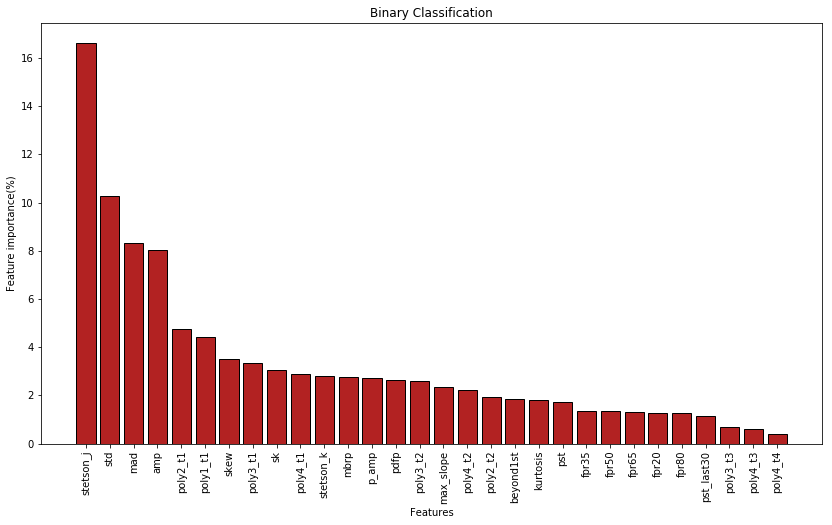

In [20]:


plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='firebrick')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature importance(%)')
plt.title("Binary Classification")
plt.savefig("../results/binFeatImportance.pdf")

In [21]:
len(all_test['target'])

4865

In [22]:
7596-sum(all_test['target'])

6529

In [23]:
from sklearn.metrics import confusion_matrix

In [25]:
cm = confusion_matrix(all_test.target, clf.predict(all_test[feats])).transpose()
cm

array([[3575,  223],
       [ 223,  844]])

3575

In [29]:
def fMeasure(precision,recall):
    return 2*precision*recall/(precision+recall)

In [27]:
precisionNon = cm[0][0]/(cm[0][0]+cm[0][1])
recallNon = cm[0][0]/(cm[0][0]+cm[1][0])
precisionT = cm[1][1]/(cm[1][1]+cm[1][0])
recallT = cm[1][1]/(cm[1][1]+cm[0][1])

In [33]:
print("Precision of transients:     {:.4f}".format(precisionT))
print("Recall of transients:        {:.4f}".format(recallT))
print("F-measure of transients:     {:.4f}".format(fMeasure(precisionT,recallT)))
print("Precision of non-transients: {:.4f}".format(precisionNon))
print("Recall of non-transients:    {:.4f}".format(recallNon))
print("F-measure of non-transients: {:.4f}".format(fMeasure(precisionNon,recallNon)))


Precision of transients:     0.7910
Recall of transients:        0.7910
F-measure of transients:     0.7910
Precision of non-transients: 0.9413
Recall of non-transients:    0.9413
F-measure of non-transients: 0.9413


# 8-Class clasification

In [35]:
labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare']
tran8 = tran.copy()
tran8.loc[~tran8.Class.isin(labels), ['Class']] = 'Other'
ntran8 = ntran.copy()




all8 = pd.concat([tran8,ntran8])

def manualFact(lab):
    labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare','Other','non-transient']
    return labels.index(lab)

all8['target'] = list(map(lambda x: manualFact(x),all8['Class']))


oversampling = all8.copy()


oversampling = oversampling.sample(frac=1)


In [36]:
recall_scores = []

#split train test class by class
all_train,all_test = splitTrainTest(oversampling)

#balance the train set
all_train= balance(all_train)



#train indices
trainIdx = all_train.index.get_level_values("ID").unique()

#remove originals that may have oversampled copies in train
all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]

#remove oversampling in test
all_test = all_test[all_test.index.get_level_values('copy_num')==0]


#format stuff
all_train.target= all_train.target.astype('int')
all_test.target= all_test.target.astype('int')

model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(all_train[feats], all_train.target)
# Copy classifier
clf = grid_search

scores = precision_recall_fscore_support(
        all_test.target, clf.predict(all_test[feats]), average='weighted')
print(['-']*30)
print(scores)
print(['-']*30)

recall_scores.append(scores)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.7807400932400932, precision=0.7776501988090797, recall=0.7807400932400932, f1_score=0.7783526865733041, total=   5.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.787004662004662, precision=0.7848435462039264, recall=0.787004662004662, f1_score=0.7848054759502749, total=   5.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.8s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=0.7837995337995338, precision=0.7815089418566237, recall=0.7837995337995338, f1_score=0.7817711076966197, total=  19.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 

In [37]:
recall_scores

[(0.8509473142441479, 0.7593582887700535, 0.7945319236328715, None)]

In [38]:
confMatr = confusion_matrix(all_test.target, clf.predict(all_test[feats])).transpose()
print(confMatr)
# 'SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare','Other','non-transient'

[[ 175   17    1    0    7    2   33   79]
 [  27  158    0    1    8    5   18   29]
 [   3    1   83    1   10    0   28   33]
 [   6    3    1   66    0    0    3  176]
 [   7   14    6    0   25    0   11   10]
 [  13    6    4    1    0   30    4  282]
 [  39    8    4    0    6    2   95  129]
 [  53    8    7    7    3   12   42 3060]]


In [39]:
print(confMatr[0,:])

[175  17   1   0   7   2  33  79]


In [40]:
newMatr = []
for i in range(len(confMatr)):
    prec = confMatr[i][i]/(sum(confMatr[i,:]))
    rec = confMatr[i][i]/(sum(confMatr[:,i]))
    newMatr.append([prec,rec,fMeasure(prec,rec),sum(confMatr[:,i])])

In [52]:
print('    Precision        Recall         F-score         Cover')
print(np.array(newMatr))

    Precision        Recall         F-score         Cover
[[5.57324841e-01 5.41795666e-01 5.49450549e-01 3.23000000e+02]
 [6.42276423e-01 7.34883721e-01 6.85466377e-01 2.15000000e+02]
 [5.22012579e-01 7.83018868e-01 6.26415094e-01 1.06000000e+02]
 [2.58823529e-01 8.68421053e-01 3.98791541e-01 7.60000000e+01]
 [3.42465753e-01 4.23728814e-01 3.78787879e-01 5.90000000e+01]
 [8.82352941e-02 5.88235294e-01 1.53452685e-01 5.10000000e+01]
 [3.35689046e-01 4.05982906e-01 3.67504836e-01 2.34000000e+02]
 [9.58646617e-01 8.05687204e-01 8.75536481e-01 3.79800000e+03]]


In [55]:
importances = clf.best_estimator_.feature_importances_*100
featsCopy = feats.copy()

Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))

yx.sort()
# yx = yx[::-1]
yx = yx[::-1]



x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]


In [56]:
x_sorted= ['stetson_j', 'sk', 'std', 'mad', 'poly2_t1', 'amp', 'p_amp', 'poly1_t1', 'pdfp', 'stetson_k', 'poly3_t1', 'max_slope', 'skew', 'poly4_t1', 'mbrp', 'kurtosis', 'fpr35', 'fpr20', 'fpr50', 'poly4_t2', 'beyond1st', 'pst_last30', 'fpr65', 'fpr80', 'pst', 'poly3_t2', 'poly2_t2', 'poly4_t3', 'poly3_t3', 'poly4_t4']

In [57]:
print(y_sorted)

[8.374326673299125, 7.613107341708797, 6.47372314533939, 5.920092209713493, 5.2001372209264725, 5.093426450824197, 4.876838148370585, 4.807961713999856, 4.172219776470673, 3.5515798372350074, 3.5013982915737407, 3.434263164676828, 3.4306745650513735, 3.2831503905469996, 2.9421181806923555, 2.676895093226318, 2.6169772813602608, 2.484430952637316, 2.3543776767987157, 2.197902012311497, 2.1770645425214217, 2.1757414994622826, 2.152794864345405, 1.9342995857559382, 1.9088867855831482, 1.8765130499287506, 1.5565131396015233, 0.5469849513050908, 0.36699827274492725, 0.2986031819884798]



[8.574116054977369, 7.366270440695763, 6.476563826087944, 6.157664438852631, 5.230425155871289, 5.18984007523864, 5.161951278916753, 4.902587796617194, 4.134958419379865, 3.8187012190017944, 3.4155000480668183, 3.3741302109976696, 3.3210996926979384, 3.184676409056053, 2.8377083989278984, 2.6536311793252394, 2.5202381312336155, 2.4435521502026814, 2.3318983179279775, 2.2124406004339603, 2.166664465046709, 2.1359716376155022, 2.1214341656023183, 1.9046675235163644, 1.8876588414451996, 1.8849228519350014, 1.4587838553582608, 0.5014180032146563, 0.33831492357990944, 0.2922098881769914]

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


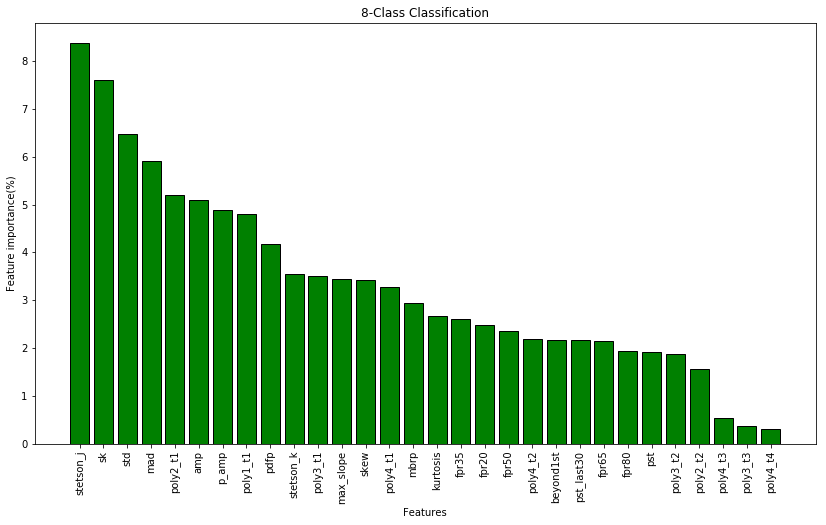

In [58]:
# from matplotlib.font_manager import FontProperties
# font = FontProperties()
# font.set_family('sans-serif')
# font.set_style('normal')

plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='#008000')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature importance(%)')
plt.title("8-Class Classification")
plt.savefig("8clasFeatImportance.pdf")